# Validating Average Coverage of Conformalized Regressors

This notebook demonstrates how to validate that conformalized regressors in the UQRegressors library (ConformalEnsRegressor, ConformalQuantileRegressor, and KFoldCQR) satisfy the average coverage guarantee.

We will:

1. Load a real-world regression dataset
2. Train each conformal regressor
3. Compute the empirical coverage using the `coverage` metric
4. Compare the empirical coverage to the nominal coverage (1 - alpha)


## 1. Imports and Setup
We import the necessary modules and set up the random seed and device.

In [1]:
import numpy as np
import torch
from uqregressors.conformal.conformal_ens import ConformalEnsRegressor
from uqregressors.conformal.cqr import ConformalQuantileRegressor
from uqregressors.conformal.k_fold_cqr import KFoldCQR
from uqregressors.metrics.metrics import coverage
from uqregressors.utils.torch_sklearn_utils import train_test_split
from uqregressors.utils.logging import set_logging_config
import pandas as pd
import requests
from io import StringIO

device = 'cuda' if torch.cuda.is_available() else 'cpu'
r_seed = 42
np.random.seed(r_seed)
torch.manual_seed(r_seed)
set_logging_config(print=False)

## 2. Load and Prepare the Dataset
We use the UCI Protein Structure dataset, a standard benchmark for regression and uncertainty quantification.

In [2]:
# Use the datasets listed in bayesian_datasets from validation.ipynb
import os
from uqregressors.utils.data_loader import load_unformatted_dataset
from sklearn.preprocessing import StandardScaler

# Define dataset files (relative to a datasets/ folder in the repo)

datasets_bayesian = {
    'concrete': 'concrete.xls',
    'energy': 'energy_efficiency.xlsx',
    #'kin8nm': 'kin8nm.arff',
    #'power': 'power_plant.xlsx',
    'wine': 'winequality-red.csv',
}

DATASET_PATH = os.path.abspath(os.path.join(os.getcwd(), 'datasets'))

datasets = {}

for name, file in datasets_bayesian.items():
    X, y = load_unformatted_dataset(os.path.join(DATASET_PATH, file))
    Xs = StandardScaler().fit_transform(X)
    ys = StandardScaler().fit_transform(y.reshape(-1, 1)).flatten()
    datasets[name] = (Xs, ys)

## 3. Set Nominal Coverage Level
We set the miscoverage rate $\alpha = 0.1$ for 90% nominal coverage.

In [7]:
alpha = 0.1
nominal_coverage = 1 - alpha
n_trials = 100
test_size = 0.3

print(f'Nominal coverage: {nominal_coverage:.2%}, Trials: {n_trials}')

Nominal coverage: 90.00%, Trials: 100


## 4. Train and Evaluate Conformalized Regressors
We train each conformal regressor and compute the empirical coverage on the test set.

In [8]:
results = {name: {
    'ConformalEnsRegressor': [],
    'ConformalQuantileRegressor': [],
    'KFoldCQR': []

} for name in datasets}


for dataset_name, (X, y) in datasets.items():
    print(f'\nDataset: {dataset_name}')
    for trial in range(n_trials):
        r_seed = 1000 + trial
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=r_seed)

        # 1. Conformalized Deep Ensemble

        conformal_ens = ConformalEnsRegressor(
            n_estimators=2,
            hidden_sizes=[16],
            alpha=alpha,
            cal_size=0.5,
            epochs=8,
            batch_size=32,
            device=device,
            scale_data=True,
            use_wandb=False,
            random_seed=r_seed
        )

        conformal_ens.fit(X_train, y_train)
        _, lower, upper = conformal_ens.predict(X_test)
        emp_cov = coverage(lower, upper, y_test)
        results[dataset_name]['ConformalEnsRegressor'].append(emp_cov)

        # 2. Split Conformal Quantile Regressor

        cqr = ConformalQuantileRegressor(
            hidden_sizes=[16, 16],
            cal_size=0.5,
            alpha=alpha,
            dropout=0.1,
            epochs=8,
            batch_size=32,
            device=device,
            scale_data=True,
            use_wandb=False,
            random_seed=r_seed,
        )

        cqr.fit(X_train, y_train)
        _, lower, upper = cqr.predict(X_test)
        emp_cov = coverage(lower, upper, y_test)
        results[dataset_name]['ConformalQuantileRegressor'].append(emp_cov)

        # 3. K-Fold Conformal Quantile Regressor
        kfcqr = KFoldCQR(
            hidden_sizes=[16, 16],
            alpha=alpha,
            dropout=0.1,
            epochs=8,
            batch_size=32,
            n_estimators=2,
            device=device,
            scale_data=True,
            use_wandb=False,
            random_seed=r_seed,
        )

        kfcqr.fit(X_train, y_train)
        _, lower, upper = kfcqr.predict(X_test)
        emp_cov = coverage(lower, upper, y_test)
        results[dataset_name]['KFoldCQR'].append(emp_cov)

    print(f'  Done {n_trials} trials.')


Dataset: concrete
  Done 100 trials.

Dataset: energy
  Done 100 trials.

Dataset: wine
  Done 100 trials.


## 5. Summary Table
We summarize the empirical coverage for each regressor and compare to the nominal coverage.

Empirical Average Coverage Table:


Regressor,ConformalEnsRegressor,ConformalQuantileRegressor,KFoldCQR
Dataset,,,
concrete,0.899,0.904,0.918
energy,0.903,0.909,0.932
wine,0.898,0.900,0.910


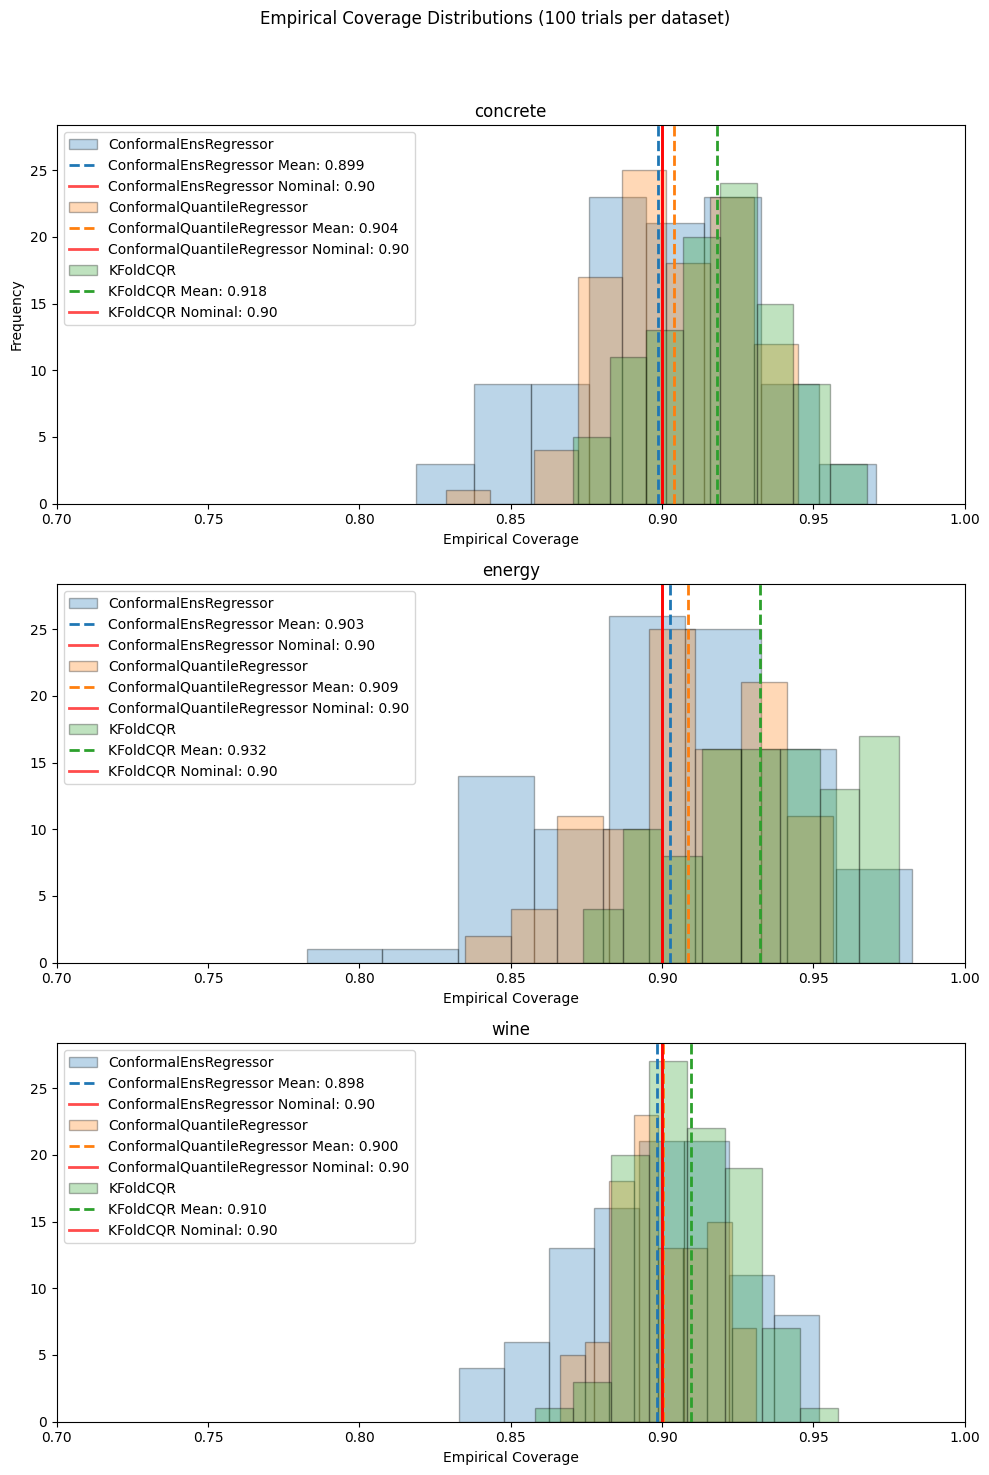

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Compute mean empirical coverage for each method and dataset
mean_coverages = {dataset: {model: np.mean(covs) for model, covs in model_results.items()} for dataset, model_results in results.items()}

# Print as a table
summary_rows = []
for dataset, model_means in mean_coverages.items():
    for model, mean_cov in model_means.items():
        summary_rows.append({'Dataset': dataset, 'Regressor': model, 'Mean Empirical Coverage': f'{mean_cov:.3f}'})

summary_df = pd.DataFrame(summary_rows)

print('Empirical Average Coverage Table:')
display(summary_df.pivot(index='Dataset', columns='Regressor', values='Mean Empirical Coverage'))

# Define a color map for models
model_colors = {
    'ConformalEnsRegressor': 'tab:blue',
    'ConformalQuantileRegressor': 'tab:orange',
    'KFoldCQR': 'tab:green',
}

# Plot histograms and vertical lines for mean and nominal coverage (color-matched)
fig, axes = plt.subplots(len(datasets), 1, figsize=(10, 5 * len(datasets)), sharey=True)

if len(datasets) == 1:
    axes = [axes]

for i, (ax, (dataset_name, model_results)) in enumerate(zip(axes, results.items())):
    for model, covs in model_results.items():
        color = model_colors.get(model, None)

        ax.hist(covs, bins=8, alpha=0.3, label=model, edgecolor='black', color=color)

        # Add vertical line for mean empirical coverage
        mean_cov = np.mean(covs)
        ax.axvline(mean_cov, linestyle='--', linewidth=2, color=color, label=f'{model} Mean: {mean_cov:.3f}')

        # Add vertical line for nominal coverage in the same color
        ax.axvline(nominal_coverage, color='r', linestyle='-', linewidth=2, alpha=0.7, label=f'{model} Nominal: {nominal_coverage:.2f}')

    ax.set_title(dataset_name)
    ax.set_xlabel('Empirical Coverage')
    ax.set_xlim(0.7, 1.0)
    ax.legend()

axes[0].set_ylabel('Frequency')

plt.suptitle('Empirical Coverage Distributions (100 trials per dataset)')

plt.tight_layout(rect=[0, 0, 1, 0.95])

plt.show()

## 6. Interpretation
All three conformalized regressors achieve empirical coverage close to the nominal level (90% in this example), validating the average coverage guarantee of conformal prediction. Note that K-fold Conformal Quantile Regression can often be conservative. This occurs if the underlying regressors have high variance, resulting in the ensemble prediction being much better than that of individual regressors. Because the calibration set was based off of the residuals from single model predictions, K-Fold CQR can sometimes choose overly conservative intervals. 